In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Input, Dense
from tensorflow.keras.models import Sequential, Model
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32

In [3]:
n_epochs = 5
learning_rate = 1.0
gamma = 0.7
num_classes = 10
input_shape = (28,28,1)

In [4]:
mnist = tf.keras.datasets.mnist

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
data_mean = 0.1307
data_std = 0.3081

In [7]:
x_train = x_train.reshape(x_train.shape[0],
                         x_train.shape[1],
                         x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0],
                         x_test.shape[1],
                         x_test.shape[2], 1)
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [8]:
x_train = (x_train.astype('float32')/255.0 - data_mean)/data_std
x_test = (x_test.astype('float32')/255.0 - data_mean)/data_std
y_train = tf.one_hot(y_train.astype(np.int32), depth=num_classes)
y_test = tf.one_hot(y_test.astype(np.int32), depth=num_classes)

In [15]:
model = Sequential(
    [
        Input(shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation="relu"),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1600)              0

In [17]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=n_epochs, validation_split=0.1)

Epoch 1/5
1688/1688 [==============================] - 19s 11ms/step - loss: 0.1965 - accuracy: 0.9388 - val_loss: 0.0509 - val_accuracy: 0.9843
Epoch 2/5
1688/1688 [==============================] - 23s 14ms/step - loss: 0.0756 - accuracy: 0.9768 - val_loss: 0.0378 - val_accuracy: 0.9903
Epoch 3/5
1688/1688 [==============================] - 23s 13ms/step - loss: 0.0589 - accuracy: 0.9817 - val_loss: 0.0449 - val_accuracy: 0.9868
Epoch 4/5
1688/1688 [==============================] - 22s 13ms/step - loss: 0.0519 - accuracy: 0.9836 - val_loss: 0.0308 - val_accuracy: 0.9912
Epoch 5/5
1688/1688 [==============================] - 23s 14ms/step - loss: 0.0457 - accuracy: 0.9856 - val_loss: 0.0313 - val_accuracy: 0.9918


In [18]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.02746419608592987
Test accuracy: 0.991100013256073


In [19]:
model.save(r'saved_models/5epoch_mnist_default')

INFO:tensorflow:Assets written to: saved_models/5epoch_mnist_default\assets


In [10]:
model = tf.keras.models.load_model(r'saved_models/5epoch_mnist_default')
model.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 3s 7ms/step - loss: 0.0275 - accuracy: 0.9911


[0.02746419608592987, 0.991100013256073]

### attack


In [12]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [35]:
random_idx = np.random.randint(x_test.shape[0])
print(random_idx)
#random_idx = 1
original_image = x_test[random_idx]
original_image = tf.convert_to_tensor(original_image.reshape((1,28,28))) #tf.convert_to_tensor(....reshape(1,28,28))
#original_image
original_label = y_test[random_idx]
original_label = original_label.reshape(1,num_classes)
original_label

1387


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)>

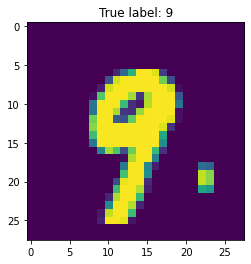

In [14]:
plt.figure()
plt.grid(False)
plt.imshow(original_image.reshape(28,28))
plt.title(f'True label: {np.argmax(original_label)}')
plt.show()

In [15]:
def create_perturbation(model_fn, input_img, true_label):
    #print(input_img.shape)
    #print(true_label, true_label.shape)
    loss_obj = tf.keras.losses.CategoricalCrossentropy() # можно использовать tf.keras.losses.MSE
    #print('loss_obj ', loss_obj)
    with tf.GradientTape() as gt:  # J(θ, x, y)
        gt.watch(input_img)
        prediction = model_fn(input_img)
        #print('prediction: ', prediction)
        loss = loss_obj(true_label, prediction)
        
    #Get the gradients for the loss
    grads = gt.gradient(loss, input_img)
    # Get the sign of the gradients to create the perturbation
    perturbation = tf.sign(grads)
    
    return perturbation

In [177]:
#from tensorflow.python.ops.numpy_ops import np_config
#np_config.enable_numpy_behavior()


### Work with one image

In [16]:
perturbation = create_perturbation(model, original_image, original_label)
perturbation_pred = model.predict(perturbation)


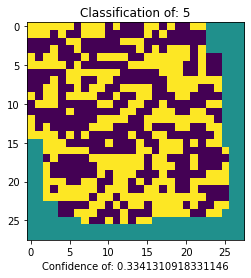

In [17]:
plt.figure()
plt.grid(False)
plt.imshow(np.reshape(perturbation,(28,28)))
plt.title(f'Classification of: {np.argmax(perturbation_pred)}')
plt.xlabel(f'Confidence of: {np.max(perturbation_pred)}')

plt.show()

In [88]:
def fgsm_one_img(model_fn, input_img, original_label, eps=0.1):
    perturbation = create_perturbation(model_fn, input_img, original_label)
    adv_img = input_img + perturbation*eps
    return adv_img

In [89]:
eps = 0.35
adv_img = fgsm_one_img(model, original_image, original_label, eps)
adv_img_pred = model.predict(adv_img)
adv_img_pred

array([[6.3406519e-04, 4.4402077e-06, 7.9955842e-04, 2.9685165e-05,
        3.7982300e-01, 7.9907237e-05, 6.1728579e-01, 1.1334267e-06,
        1.3410518e-03, 1.3574737e-06]], dtype=float32)

In [92]:
adv_img=adv_img.numpy()

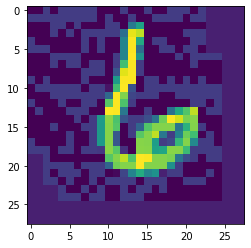

In [93]:
plt.imshow(adv_img.reshape(28,28))

### Visualize one image

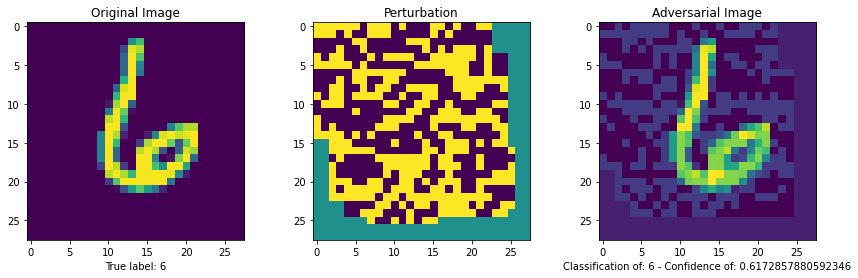

In [94]:
plt.figure()
plt.grid(False)

plt.subplot(1,3,1)
plt.subplots_adjust(right = 2)
plt.title("Original Image")
#убрать решэйп
plt.imshow(np.reshape(original_image,(28,28)))
plt.xlabel(f'True label: {np.argmax(original_label)}')

plt.subplot(1,3,2)
plt.subplots_adjust(right = 2)
plt.title("Perturbation")
plt.imshow(np.reshape(perturbation,(28,28)))


plt.subplot(1,3,3)
plt.subplots_adjust(right = 2)
plt.title("Adversarial Image")
plt.imshow(np.reshape(adv_img,(28,28)))
plt.xlabel(f'Classification of: {np.argmax(adv_img_pred)} - Confidence of: {np.max(adv_img_pred)}')

plt.show()

### Work with all/several images


In [95]:
fgsm_data = []
def fgsm_all_img(model_fn, x_dataset, dataset_labels, eps = 0.1):
    for i in range(len(x_dataset)):        
        original_img = tf.convert_to_tensor(x_dataset[i].reshape((1,28,28))) #make a tensor not a numpy
        original_label = dataset_labels[i]
        original_label = original_label.reshape(1,num_classes) #make shape (1,10)
        img_adv = fgsm_one_img(model_fn, original_img, original_label, eps)
        
        img_adv = img_adv.numpy()
        fgsm_data.append(img_adv)
        
    
    return fgsm_data

In [96]:
#x_train_fgsm = fgsm_all_img(model, x_train[:10], y_train[:10], eps = 0.5)

In [56]:
#x_train_fgsm = fgsm_all_img(model, x_train, y_train, eps = 0.01)
x_test_fgsm = fgsm_all_img(model, x_test[:10], y_test[:10], eps = 0.4)

In [58]:
original_images = x_test[:10]
original_labels = y_test[:10]

In [68]:
adv_imgs=x_test_fgsm[:10]
adv_img_preds = []
#for i in range(len(adv_imgs)):
 #   adv_img_preds.append(np.argmax(model.predict(adv_imgs[i])))
adv_img_preds = get_label_predictions(model, adv_imgs)    
adv_img_preds

[7, 2, 1, 0, 9, 1, 8, 4, 6, 9]

In [30]:
# prepare image for showing
def prepare_img(x):
    return np.reshape(x,(28,28))

In [32]:
#return class or label
def prepare_label(y):
    return np.argmax(y)

In [54]:
def display_image_pair(clean_image, clean_label, adv_image, adv_image_label):
    fig, ax = plt.subplots(1, 3, figsize=(10,5))
    ax[0].imshow(prepare_img(clean_image))
    ax[0].axis('off')
    ax[0].set_title("Original", fontsize=15)
    ax[0].text(0.5,-0.13, f'True label: {prepare_label(clean_label)}', size=12, ha='center', transform=ax[0].transAxes)
    
    ax[1].imshow(prepare_img(adv_image))
    ax[1].axis('off')
    ax[1].set_title("Adversarial", fontsize=15)
    ax[1].text(1.8,-0.13, f'Pred label: {prepare_label(adv_image_label)}', size=12, ha='center', transform=ax[0].transAxes)
    
    ax[2].axis("off")
    plt.show()

In [48]:
#prepare_img(original_image), 
#prepare_label(original_label)
len(original_image)

1

In [52]:
len(adv_img)
#prepare_img(adv_img)
#prepare_label(adv_img_pred)

1

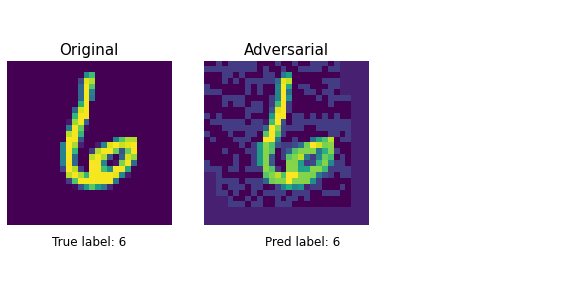

In [55]:
display_image_pair(original_image, original_label,  adv_img, adv_img_pred)

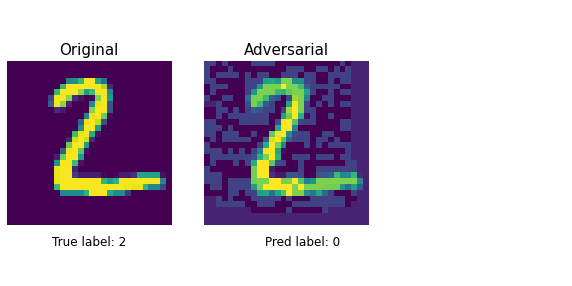

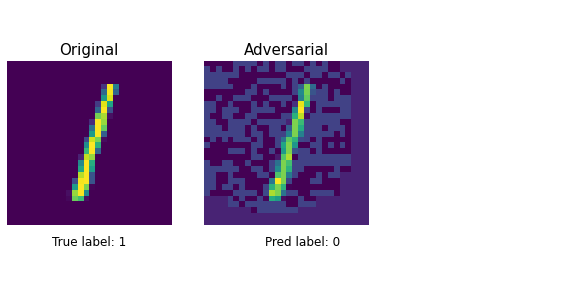

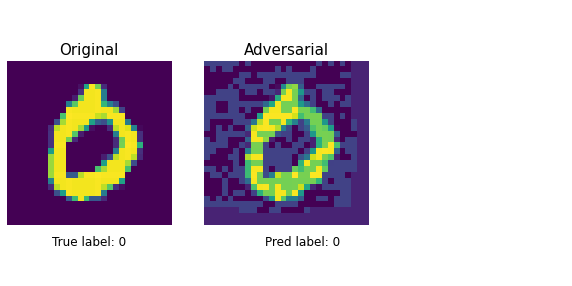

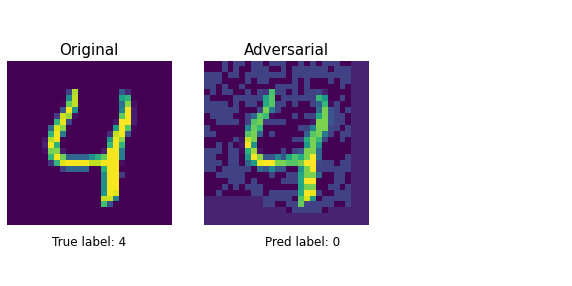

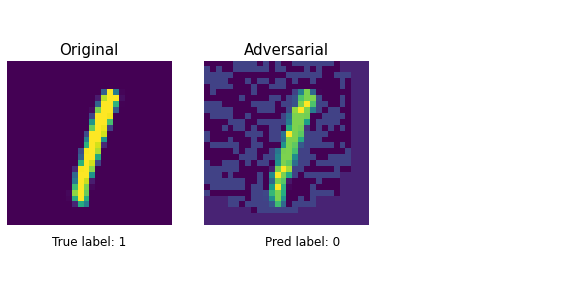

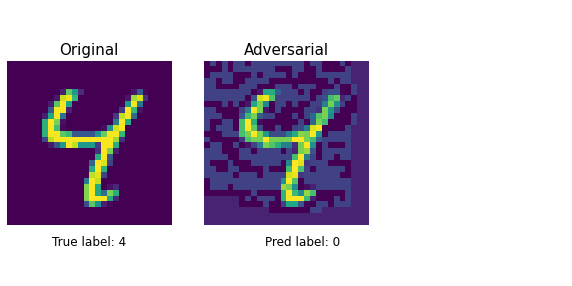

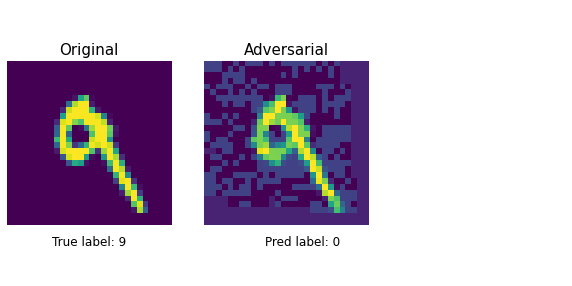

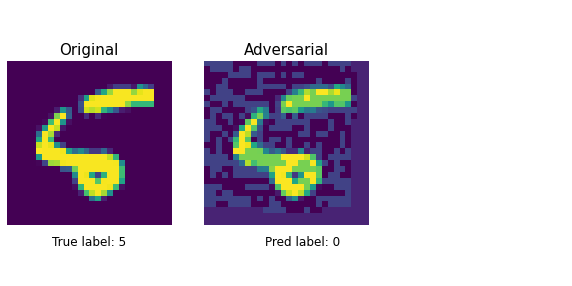

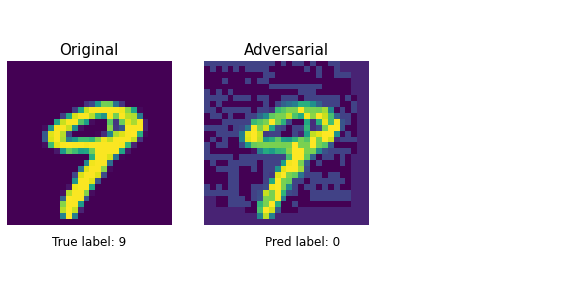

In [60]:
for i in range(1,10):
    display_image_pair(original_images[i], original_labels[i], adv_imgs[i], adv_img_preds[i])

In [61]:
y_train

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

In [67]:
def get_label_predictions(model, x_data):
    y_data = []
    for i in range(len(x_data)):
        y_data.append(np.argmax(model.predict(x_data[i])))
    return y_data

In [69]:
model_autoencoder_easy = tf.keras.models.Sequential([
    #encoder
    tf.keras.layers.Dense(256, activation = 'relu', input_shape=input_shape),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    
    #decoder
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(28*28, activation = 'sigmoid')
])

In [70]:
model_autoencoder_easy.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [102]:
x_train[0].shape

(28, 28, 1)

In [97]:
adv_imgs[0].shape

TensorShape([1, 28, 28])

In [107]:
for i in range(len(x_train_fgsm)):
    x_train_fgsm[i] = x_train_fgsm[i].reshape(28,28,1)
x_train_fgsm[0].shape

(28, 28, 1)

### generate adv datasets

In [109]:
def adversarial_pattern(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:   # J(θ, x, y)
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image) # ∇ₓ
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [119]:
import random
def generate_adversarials(batch_size):
    while True:
        x = []
        y = []
        for batch in range(batch_size):
            #N = random.randint(0, 100)

            label = y_train[batch]
            image = x_train[batch]
            
            perturbations = adversarial_pattern(image.reshape((1, 28, 28, 1)), label).numpy()
            
            
            epsilon = 0.9
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_train[batch])
        
        
        x = np.asarray(x).reshape((batch_size, 28, 28, 1))
        y = np.asarray(y)
        
        yield x, y

In [117]:
x_adversarial_test, y_adversarial_test = next(generate_adversarials(10000)) 
print("Base accuracy on adversarial images:", model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0))

Base accuracy on adversarial images: [3.2653565406799316, 0.14749999344348907]


In [120]:
x_adversarial_train = next(generate_adversarials(60000)) 

In [140]:
x_adv_train, y_adv_train = x_adversarial_train

In [142]:
len(x_adv_train)

60000

In [143]:
y_adv_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [146]:
tf.config.run_functions_eagerly(True)


In [148]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,mode='min')
model_autoencoder_easy.fit(x_adv_train, x_train, 
                           epochs=5,
                           batch_size=BATCH_SIZE,
                           shuffle=False,
                           callbacks=[early_stop])

Epoch 1/5
 308/1875 [===>..........................] - ETA: 17:38 - loss: 0.5220 - mae: 0.5921

KeyboardInterrupt: 

In [126]:
type(x_adversarial_train)

tuple

In [129]:
x_adversarial_train[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [138]:
len(x_adversarial_test)

10000

In [137]:
len(x_test)

10000

In [139]:
type(x_adversarial_test), type(x_test)

(numpy.ndarray, numpy.ndarray)